# Second Order Cumulant Expansion Method:

#### a. Obtaining the analytic equations of motion (and print all the variables in the equations of motion):

In [1]:
using QuantumCumulants

# Building the Hilbert space:
(hil_a,hil_b,hil_c) = (FockSpace(:pump),FockSpace(:signal), FockSpace(:idler))
hilbert_space = hil_a ⊗ hil_b ⊗ hil_c

# Defining the operators with labels "a", "b" and "c" in pump, signal and idler subspaces respectively:
(oper_a,oper_b,oper_c)= (Destroy(hilbert_space,:a,1), Destroy(hilbert_space,:b,2), 
                               Destroy(hilbert_space,:c,3))

# Hamiltonian:
hami =im*oper_a*oper_b'*oper_c'-im*oper_a'*oper_b*oper_c 

# Analytic equations of motion:
##################################################################
#finds all the second-order operators
relev_operators=find_operators(hilbert_space,2)
#finds all the equations using the second order cumulant expansion:
eqns_motion_analy = meanfield(relev_operators, hami; order=2)

# Printing the variables associated with the equations of motion:
################################################################
ll=range(1,length(eqns_motion_analy),step=1)
temp_table = fill("", 15) #array of strings
for ii in ll
       temp_table[ii]="$ii: $(eqns_motion_analy[ii].lhs)"
       end
x=reshape(temp_table,(3,5)) # building a table of all variables
Base.print_matrix(stdout, x) # printing the table of all variables

 "1: ⟨a⟩"  "4: ⟨a*b⟩"   "7: ⟨a*b′⟩"  "10: ⟨b*c⟩"   "13: ⟨b*b⟩"
 "2: ⟨b⟩"  "5: ⟨a*c⟩"   "8: ⟨a*c′⟩"  "11: ⟨b′*b⟩"  "14: ⟨c′*c⟩"
 "3: ⟨c⟩"  "6: ⟨a′*a⟩"  "9: ⟨a*a⟩"   "12: ⟨b*c′⟩"  "15: ⟨c*c⟩"

#### Setting up parameters and solving the ODE:

In [3]:
using ModelingToolkit
using OrdinaryDiffEq

ALP_SQ = 100  # alpha square
ALP=sqrt(ALP_SQ) ## alpha

# Setting up the time array for evolution:
T_END = 0.40 # Total time of the evolution
DELT_T = 0.001 # Time step for the evolution
t_arr = LinRange(0, T_END,round(Int, T_END / DELT_T) + 1);
################################################################################
# Time window and Δt of relevance for our analysis to help the user:
#t_end=0.40,  Δt=0.01 for alp_sq=100
#t_end=0.17,  Δt=0.001 for alp_sq=1000
#t_end=0.065, Δt=0.0001 for alp_sq=10000
#########################################################################3
# Initial conditions for the ODE:
sol_ini = zeros(ComplexF64,15)
sol_ini[1]=ALP #<a>
sol_ini[6]=ALP_SQ #<a'a>
sol_ini[9]=ALP_SQ #<aa>

#Solving the ODE:
@named system_eqns = ODESystem(eqns_motion_analy)
problem = ODEProblem(system_eqns,sol_ini,(0.0,last(t_arr)));
sol = solve(problem,Tsit5(),abstol=1e-16,reltol=1e-16, saveat = t_arr);

#### 1. Plotting the populations:

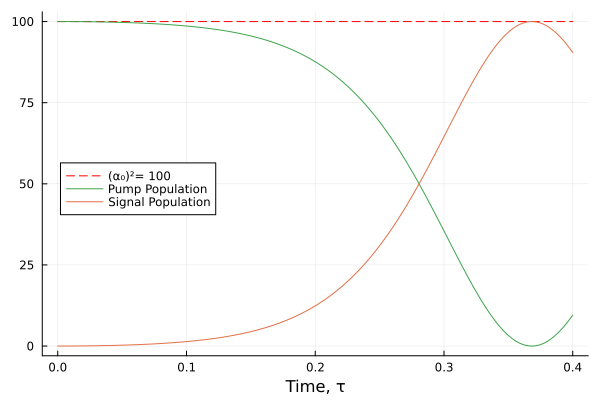

In [4]:
using Plots
plot([0, last(t_arr)], [ALP_SQ, ALP_SQ],ls=:dash,color=:red,label="(α₀)²= $ALP_SQ")
plot!(sol.t,real.(sol[oper_a'*oper_a]),label="Pump Population",color=3)
plot!(sol.t,real.(sol[oper_b'*oper_b]),xlabel="Time, τ",label="Signal Population",legend=:left,color=2)

#### 2. Plotting the pump variance:

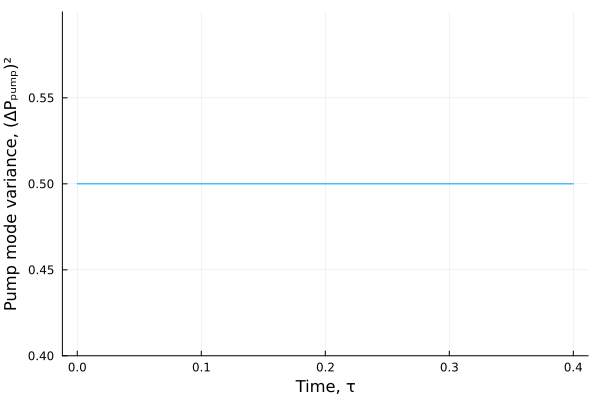

In [5]:
## Eq. C12 in the manuscript:
deltsq_pump_momtm= real.(0.5 .+ sol[oper_a'*oper_a] .- sol[oper_a*oper_a])

plot(sol.t,deltsq_pump_momtm,label="",xlabel="Time, τ",
                                 ylabel="Pump mode variance, (ΔPₚᵤₘₚ)²",ylims=(0.4,0.6))

#### 3. Zero-delay autocorrelation function:

The autocorrelation functions are given by
\begin{align}
    g^{(2)}_{p}&=\frac{\langle \psi(\tau)|(a_{p}^{\dagger})^{2}a_{p}^{2}|\psi(\tau)\rangle}{\left(\langle\psi(\tau)| a_{p}^{\dagger}a_{p}|\psi(\tau)\rangle\right)^{2}} 
     =\frac{\langle \alpha(\tau)|(a_{p}^{\dagger})^{2}a_{p}^{2}|\alpha(\tau)\rangle}{\left(\langle\alpha(\tau)| a_{p}^{\dagger}a_{p}|\alpha(\tau)\rangle\right)^{2}} =1  \\
    g^{(2)}_{s}&=\frac{\langle \psi(\tau)|(a_{s}^{\dagger})^{2}a_{s}^{2}|\psi(\tau)\rangle}{\left(\langle\psi(\tau)| a_{s}^{\dagger}a_{s}|\psi(\tau)\rangle\right)^{2}} 
    =\frac{\sum_{n}\frac{\left(\tanh\eta(t)\right)^{2n}}{\cosh^2 \eta(t)} n(n-1)}{\sum_{n}\frac{\left(\tanh\eta(t)\right)^{2n}}{\cosh^2 \eta(t)} n} =2 
\end{align}

#### 4. Exporting the data (if required):

In [6]:
## For writing the data:
#using NPZ
#npzwrite("Cumulant_$(ALP_SQ)_alpha_squared_level2.npy", 
#Dict("time" => sol.t, "pump_population" => real.(sol[oper_a'*oper_a]),
#"signal_population" => real.(sol[oper_b'*oper_b]),"pump_variance_momentum" => deltsq_pump_momtm))

## Can read the data from the output file as follows:
#data = npzread("Cumulant_$(ALP_SQ)_alpha_squared_level2_population.npy")
#getindex.(Ref(data), "time")
#getindex.(Ref(data), "sig_pop")